결정 트리는 일련의 질문에 대한 결정을 통해 데이터를 분해하는 모델이다. 자세한 설명은 아래 영상 참고
- [의사결정트리](https://youtu.be/n0p0120Gxqk)
- [의사결정트리 - ID3 알고리즘](https://youtu.be/UPKugq0fK04)
- [랜덤포레스트](https://youtu.be/nZB37IBCiSA) 

결정 알고리즘을 사용하면 트리 루트에서 시작해서 IG(information gain)이 최대가 되는 특성으로 데이터를 나눈다.<br>
일반적으로 overfitting될 가능성을 낮추기 위해서 트리의 최대 깊이를 제한한다.(pruning)

IG는 다음과 같이 정의한다.

$$IG(D, f)=I(D_p)-\sum_{j=1}^m{N_j \over N_p}I(D_j)$$

$f$는 분할에 사용할 특성이다.<br>
$D_p$는 부모 노드의 데이터셋이다.<br>
$D_j$는 j번째 자식 노드의 데이터셋이다.<br>
$I$는 불순도 지표이다.<br>
$N_p$는 부모 노드에 있는 전체 샘플 개수이다.<br>
$N_j$는 j번째 자식 노드에 있는 샘플 개수이다.<br>

IG는 단순히 부모 노드의 불순도와 자식 노드의 불순도 합의 차이이다.<br>
자식 노드의 불순도가 낮을수록 IG는 커진다.<br>

결정 트리에 널리 사용되는 불순도 지표는 다음 세가지이다.
- 지니 불순도(Gini impurity)
- 엔트로피(Entropy)
- 분류 오차(classification error)

엔트로피의 정의는 다음과 같다. 

$$I_H(t)=-\sum_{i=1}^cp(i|t)\log_2p(i|t)$$

$p(i|t)$는 특정 노드 $t$에서 클래스 $i$에 속한 샘플의 비율이다.

한 노드의 모든 샘플이 같은 클래스이면 엔트로피는 0이다.<br>
클래스의 분포가 균등하면 엔트로피는 최대가 된다.<br>
지니불순도도 엔트로피와 유사하게 완벽하게 섞여 있을 때 최대가 된다.<br>

보통 불순도 조건을 바꾸어 트리를 평가하는 것보다 트리의 깊이를 바꾸면서 튜닝하는 것이 낫다.<br>
내 생각에는 그냥 엔트로피나 지니 불순도를 쓰면 된다.

결정 트리는 특성 공간을 사각 격자로 나누기 때문에 복잡한 결정 경계를 만들수 있다.
결정 트리가 깊어질수록 결정 경계가 복잡해지고, overfitting되기 쉽다.
결정 트리 알고리즘은 특성의 스케일을 조정할 필요가 없다.

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

iris = datasets.load_iris()     # 붓꽃 데이터 로드
x = iris.data[:, [2, 3]]        # 꽃잎길이, 꽃잎너비 특성을 x에 할당
y = iris.target                 # 꽃 품종에 해당하는 클래스 레이블을 y에 할당
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)


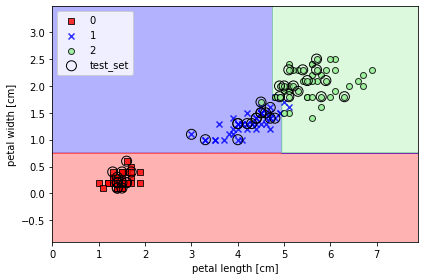

In [3]:
# 결정트리에 지니불순도를 사용한 붓꽃 데이터 결정 경계 그리기 

from common import utils
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(x_train, y_train)
x_combined = np.vstack((x_train, x_test))
y_combined = np.hstack((y_train, y_test))

utils.plot_decision_regions(x_combined, y_combined, classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 랜덤 포레스트로 여러 개의 결정 트리 연결

랜덤 포레스트는 결정 트리의 앙상블이다.<br>
랜덤 포레스트는 여러개의 (깊은) 결정 트리의 평균을 내는 것이다.<br>
앙상블은 결정 트리의 높은 분산 문제를 해결하고, 성능을 높이고 overfitting 문제를 줄인다.<br>

랜덤 포레스트는 다음과 같은 단계로 진행한다.

1. 훈련 데이터셋에서 n개의 랜덤한 bootstrap 샘플을 뽑는다.(중복 허용)
2. bootstrap 샘플에서 결정 트리를 학습한다.(모든 특성을 평가하지 않고, 랜덤하게 선택된 일부 특성만 사용)
    1. 중복을 허용하지 않고 d개의 특성을 선택한다.
    2. IG와 같은 목적 함수를 기준으로 최선의 분할을 만드는 특성을 사용해서 노드를 분한한다.
3. 단계 1과 2를 k번 반복한다.
4. 각 트리의 예측을 모아 다수결 투표로 클래스 레이블을 할당한다.

랜덤 포레스트는 해석이 쉽지 않지만, 하이퍼파라미터 튜닝에 노력을 줄여준다.<br>
랜덤 포레스트는 트리의 깊이를 튜닝할 필요가 없다.<br>
단계 3의 k가 클수록 분류기의 성능이 좋아진다.<br>
bootstrap 샘플 크기가 작아지면, 랜덤 포레스트의 전체적인 성능이 줄어든다.<br>
반대로 bootstrap 샘플 크기가 커지면, overfitting 가능성이 늘어난다.<br>
일반적으로 bootstrap 샘플의 크기는 균형 잡힌 편향-분산을 위해서 훈련 데이터셋과 동일하게 한다.<br>
일반적으로 분할에 사용하는 특성 d는 훈련 세트에 있는 전체 특성 개수가 m일때 $d=\sqrt{m}$로 지정한다.<br>

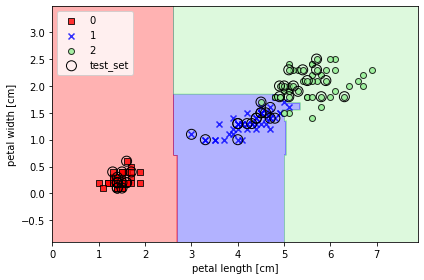

In [4]:
# 랜덤 포레스트를 사용해서 붓꽃 데이터 결정 경계 그리기

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion='gini',   # 지니불순도 사용
    n_estimators=25,    # 25개의 결정 트리를 사용
    random_state=1, 
    n_jobs=2            # 2개 코어를 사용해서 모델 훈련을 병렬화 
)
forest.fit(x_train, y_train)

utils.plot_decision_regions(x_combined, y_combined, classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
